# Visualize othello board with highlighted background

Input to the model: "int", doesn't contain middle pieces
For plotting and correct conversion to board visualization: "string", does mind middle pieces 

In [1]:
import os
import pickle
from IPython.display import HTML

import torch as t
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from circuits.dictionary_learning.buffer import NNsightActivationBuffer
from circuits.dictionary_learning.dictionary import AutoEncoder, AutoEncoderNew, GatedAutoEncoder
import circuits.othello_utils as othello_utils
from circuits.utils import (
    chess_hf_dataset_to_generator,
    othello_hf_dataset_to_generator,
    get_model,
    get_submodule,
)

repo_dir = '/home/can/chess-gpt-circuits'
device = 'cuda:0'

In [2]:
# download data from huggingface if needed
if not os.path.exists(f'{repo_dir}/autoencoders/group-2024-05-17_othello'):
    hf_hub_download(repo_id='adamkarvonen/othello_saes', filename='group-2024-05-17_othello.zip', local_dir=f'{repo_dir}/autoencoders')
    # unzip the data
    os.system(f'unzip {repo_dir}/autoencoders/group-2024-05-17_othello.zip -d autoencoders')

In [3]:
# load SAE
ae_type = 'standard_new'
trainer_id = 0

ae_path = f'{repo_dir}/autoencoders/group-2024-05-17_othello/group-2024-05-17_othello-{ae_type}/trainer{trainer_id}'
if ae_type == 'standard':
    ae = AutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'gated':
    ae = GatedAutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'standard_new':
    ae = AutoEncoderNew.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
else:
    raise ValueError('Invalid ae_type')

In [14]:
# load information about features
with open(os.path.join(ae_path, 'indexing_find_dots_indices_n_inputs_1000_feature_labels.pkl'), 'rb') as f:
    results = pickle.load(f)

def to_device(d, device=device):
    if isinstance(d, t.Tensor):
        return d.to(device)
    if isinstance(d, dict):
        return {k: to_device(v, device) for k, v in d.items()}
results = to_device(results)

In [4]:
# load model and data

layer = 5
context_length = 59
activation_dim = 512  # output dimension of the layer
model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
dataset_name = "taufeeque/othellogpt"

model = get_model(model_name, device)
submodule = get_submodule(model_name, layer, model)

data = othello_hf_dataset_to_generator(
    dataset_name, context_length=context_length, split="train", streaming=True
)
buffer = NNsightActivationBuffer(
    data,
    model,
    submodule,
    n_ctxs=8e3,
    ctx_len=context_length,
    refresh_batch_size=128,
    io="out",
    d_submodule=activation_dim,
    device=device,
)

Loaded pretrained model Baidicoot/Othello-GPT-Transformer-Lens into HookedTransformer
Moving model to device:  cuda:0


Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
def convert_othello_dataset_sample_to_board(sample_i, move_idx=None):
    if type(sample_i) == t.Tensor:
        sample_i = sample_i.tolist()
    context = [othello_utils.itos[s] for s in sample_i]
    if move_idx is not None:
        context = context[:move_idx+1]
    board_state_RR = othello_utils.games_batch_to_state_stack_mine_yours_BLRRC([context])[0][-1]
    board_state_RR = t.argmax(board_state_RR, dim=-1) - 1
    return board_state_RR

game_idx = 0
move_idx = 20
sample_game = buffer.text_batch()[game_idx] # in "model input format"
sample_board = convert_othello_dataset_sample_to_board(sample_game, move_idx=move_idx)
sample_board

tensor([[ 0,  0,  1,  0, -1,  1,  0,  0],
        [ 0,  1,  0, -1,  1,  0,  0,  0],
        [ 0,  0, -1,  1,  1,  0, -1,  0],
        [ 0, -1,  0,  1,  1, -1,  0,  0],
        [ 0,  0,  0,  1, -1,  1,  1,  0],
        [ 0,  0,  0, -1,  1,  1,  1,  0],
        [ 0,  0, -1,  0,  0,  0,  0,  1],
        [ 0, -1,  0,  0,  0,  0,  0,  0]])

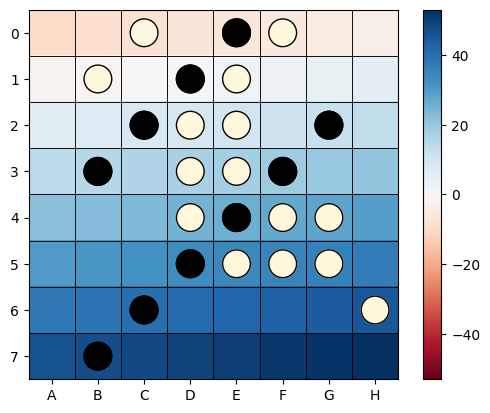

In [94]:
def plot_othello_board_highlighted(true_board_RR, bg_board_RR=None, title=''):
    """
    Plots a comparison of the true and reconstructed Othello boards using matplotlib.

    Args:
    true_board (torch.Tensor): A 2D tensor representing the true Othello board.
    recon_board (torch.Tensor): A 2D tensor representing the reconstructed Othello board.
    """

    true_color_map = {-1: 'black', 0: 'white', 1: 'cornsilk'}
    if bg_board_RR is None:
        bg_board_RR = t.zeros_like(true_board_RR)
        cmap = plt.matplotlib.colors.ListedColormap(['white'])
        print_color_bar = False
        vmin = 0
        vmax = 0
    else:
        bg_max_abs = t.abs(bg_board_RR).max().item()
        if bg_board_RR.min() < 0:
            cmap = "RdBu"
            vmin = -bg_max_abs
            vmax = bg_max_abs
        else:
            cmap = "Blues"
            vmin = 0
            vmax = bg_board_RR.max().item()
        print_color_bar = True

    # Create a figure and axis for the plot
    fig, ax = plt.subplots()
    plt.imshow(bg_board_RR, cmap=cmap, vmin=vmin, vmax=vmax)
    # add circles on each square with black borders
    for i in range(8):
        for j in range(8):
            plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='black', lw=0.5))
            if true_board_RR[i, j].item() == 0:
                continue
            circle = plt.Circle((j, i), 0.3, color=true_color_map[true_board_RR[i, j].item()], fill=True)
            circle_edges = plt.Circle((j, i), 0.3, color='black', fill=False)
            plt.gca().add_artist(circle)
            plt.gca().add_artist(circle_edges)
    plt.xticks(range(8), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
    plt.title(title)
    if print_color_bar:
        # align colorbar to zero
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)

    # plt.savefig('othello_board_highlighted.png', dpi=300)
    plt.show()


# Test visualization
random_bg = t.arange(-10,54).reshape(8,8)
plot_othello_board_highlighted(sample_board, random_bg)

In [95]:
def plot_game_seq(context_i, bg_values, true_board_RR, max_act, prefix=''):
    context_s = [othello_utils.itos[s] for s in context_i]
    bg_board_RR = t.zeros((8, 8))
    for act, token in zip(bg_values, context_s):
        bg_board_RR[token // 8, token % 8] = act
    plot_othello_board_highlighted(true_board_RR, bg_board_RR=bg_board_RR, max_bg=max_act, title=prefix)

In [96]:
# functions for visualizing highlighted token sequences
def shade(value, max_value):
    if abs(value) > max_value:
        raise ValueError("Absolute value must be less than or equal to max_value.")
    
    normalized_value = value / max_value
    
    if normalized_value < 0:
        # Red shade for negative values
        red = 255
        green = int(255 * (1 + normalized_value))
        blue = int(255 * (1 + normalized_value))
    else:
        # Blue shade for positive values
        red = int(255 * (1 - normalized_value))
        green = int(255 * (1 - normalized_value))
        blue = 255
    
    # White color for zero value
    if value == 0:
        red = green = blue = 255
    
    # Convert RGB values to hex color code
    hex_color = "#{:02x}{:02x}{:02x}".format(red, green, blue)
    
    return hex_color

def visualize_game_seq(context_i, activations, max_value, prefix=''):
    context_s = [othello_utils.itos[s] for s in context_i]
    labeled_seq = list(map(othello_utils.to_board_label, context_s))
    html_elements = []
    for token, act in zip(labeled_seq, activations):
        hex_color = shade(act, max_value)
        s = token
        s = s.replace(' ', '&nbsp;')
        html_element = f'<span style="background-color: {hex_color}; color: black">{s}</span>'
        html_elements.append(html_element)
    
    combined_html = ' '.join(html_elements)
    combined_html = prefix + combined_html
    return HTML(combined_html)

In [103]:
def plot_game_seq(context_i, bg_values, true_board_RR, prefix=''):
    context_s = [othello_utils.itos[s] for s in context_i]
    bg_board_RR = t.zeros((8, 8))
    for act, token in zip(bg_values, context_s):
        bg_board_RR[token // 8, token % 8] = act
    plot_othello_board_highlighted(true_board_RR, bg_board_RR=bg_board_RR, title=prefix)

def visualize(model, ae, buffer, feat_idx, k=10):
    labeled_seq = buffer.token_batch()
    with model.trace(labeled_seq, scan=False, validate=False): # use_cache=False,  output_attentions=False
        embeds = model.hook_embed.output.save()
        embeds.retain_grad()
        x = submodule.output
        f = ae.encode(x).save()
    mean_embed = embeds.value.mean(dim=(0,1))
    f = f.value[...,feat_idx]

    # get indices of top k exemplars

    def unravel_index(indices, shape):
        out = []
        for dim in reversed(shape):
            out.append(indices % dim)
            indices = indices // dim
        return tuple(reversed(out))

    flattened_f = f.flatten()
    top_values, top_indices_flattened = t.topk(flattened_f, k)
    top_indices = unravel_index(top_indices_flattened, f.shape)
    top_values.sum().backward(retain_graph=True)
    print(embeds.value.grad.sum())

    # compile top contexts and activations
    contexts, activations, attributions = [], [], []
    for i in range(k):
        context_idx, token_idx = top_indices[0][i].item(), top_indices[1][i].item()
        contexts.append(labeled_seq[context_idx, :token_idx+1].tolist())
        activations.append(f[context_idx, :token_idx+1].tolist())
        attributions.append(
            (embeds.value.grad * (embeds.value - mean_embed)).sum(dim=-1)[context_idx, :token_idx+1].tolist()
        )
    max_value = max([abs(x) for act in activations for x in act] + [abs(x) for att in attributions for x in att])

    for cnt, (context_i, activation, attribution) in enumerate(zip(contexts, activations, attributions)):
        print("="*80)
        print(f'Top {cnt+1} example:')
        board_state_RR = convert_othello_dataset_sample_to_board(context_i)
        display(visualize_game_seq(context_i, activation, max_value, prefix='feature activations: '))
        plot_game_seq(context_i, activation, board_state_RR, prefix='activations on board: ')
        display(visualize_game_seq(context_i, attribution, max_value, prefix='promoting tokens: '))
        plot_game_seq(context_i, attribution, board_state_RR, prefix='promoting tokens on board: ')

    return contexts[0], activations[0], attributions[0]

# Here's the interactive part

Key for mapping from the last entry of the board state tensor to pieces:
* 0 => black king
* 1 => black queen
* 2 => black rook
* 3 => black bishop
* 4 => black knight
* 5 => black pawn
* 6 => empty
* 7 => white pawn
* 8 => white knight
* 9 => white bishop
* 10 => white rook
* 11 => white queen
* 12 => white king

Board states that the feature classifies according to Adam's measurements:
tensor([], device='cuda:0', size=(0, 3), dtype=torch.int64)
Number of such board states:
tensor(0, device='cuda:0')
tensor(0.5794, device='cuda:0')
Top 1 example:


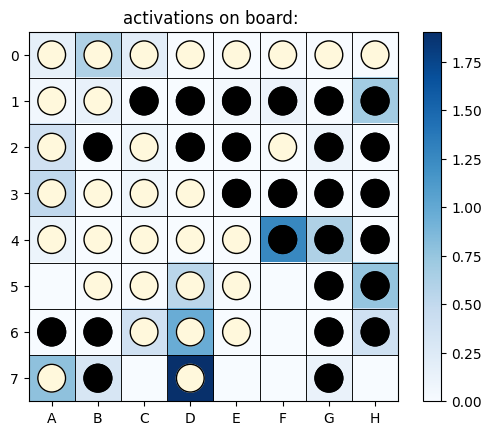

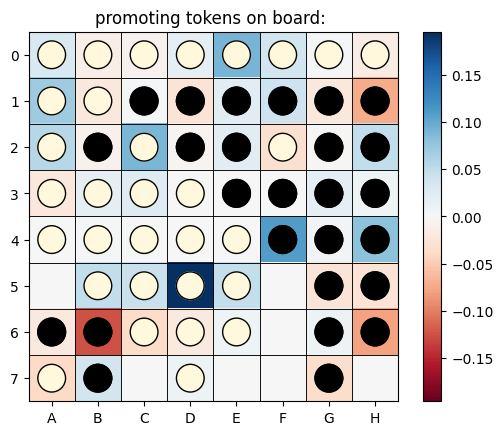

Top 2 example:


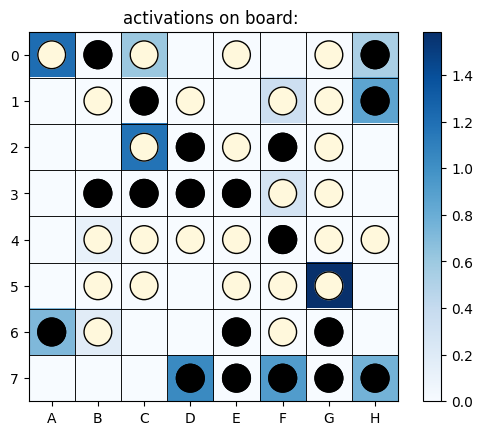

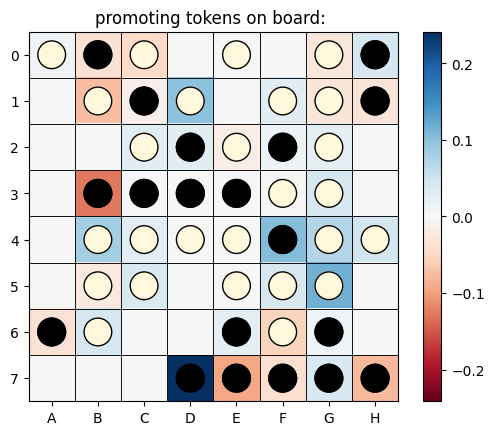

Top 3 example:


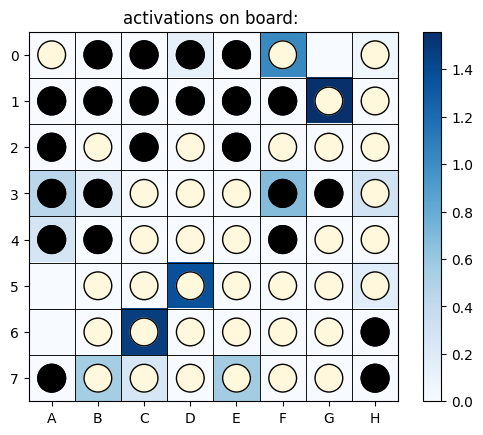

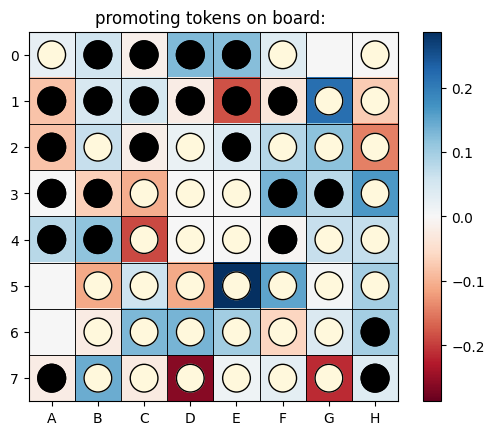

Top 4 example:


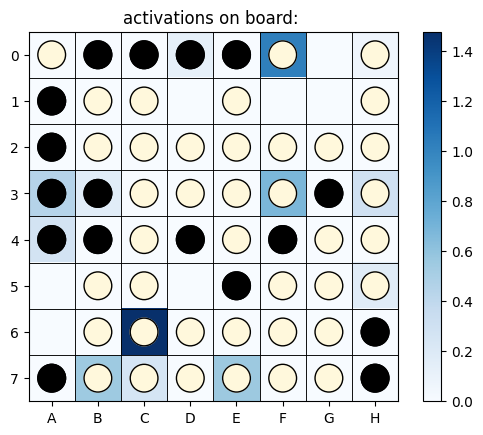

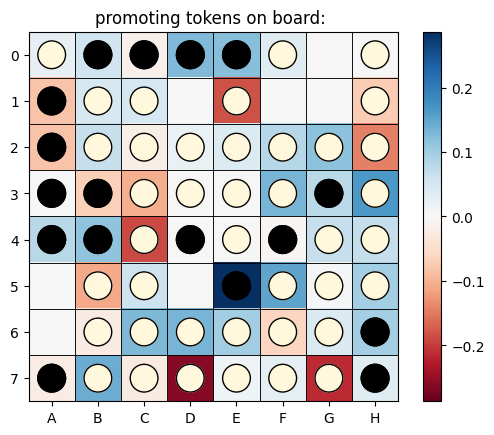

Top 5 example:


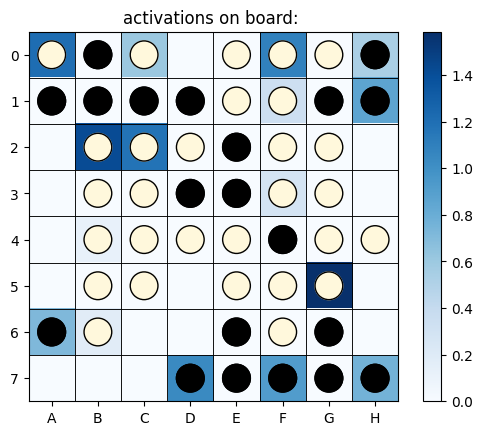

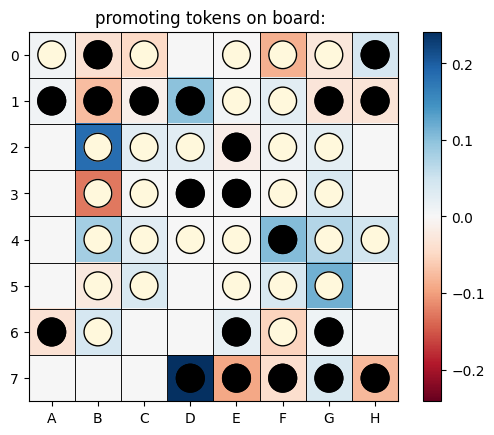

Top 6 example:


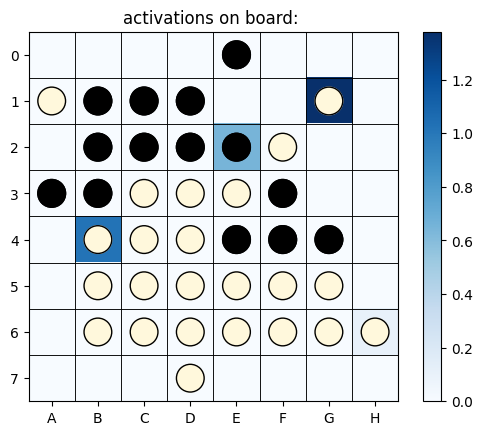

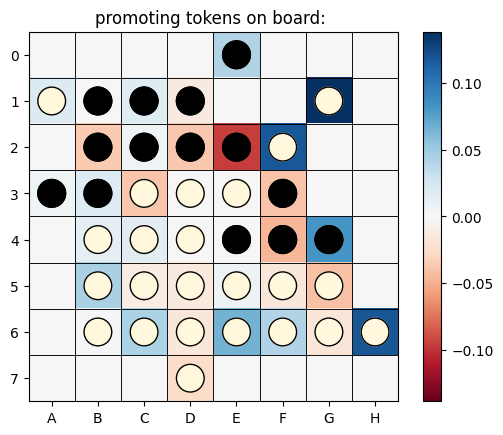

Top 7 example:


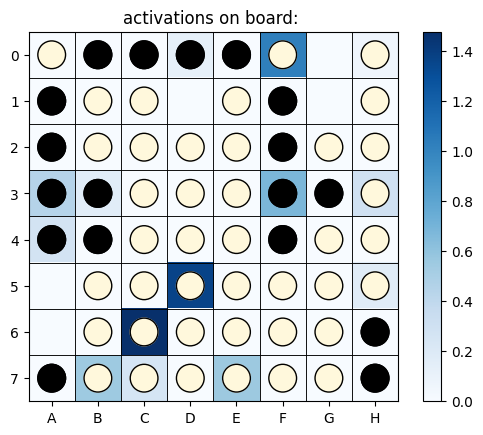

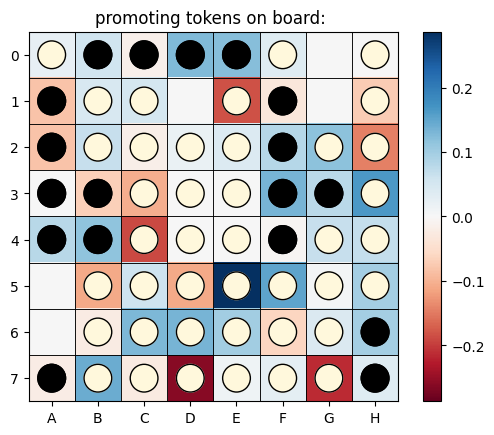

Top 8 example:


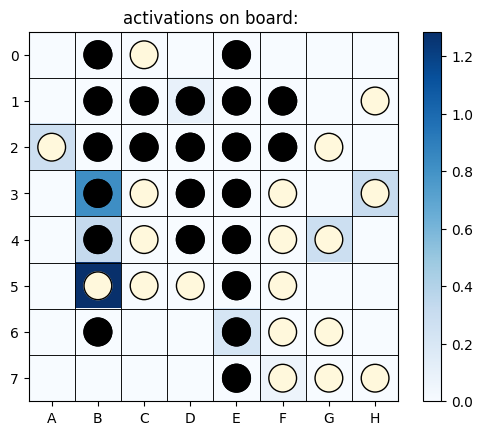

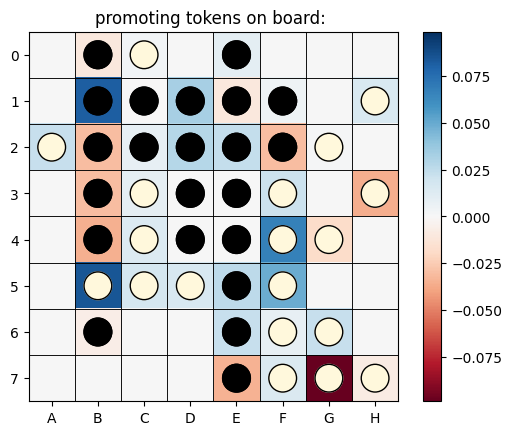

Top 9 example:


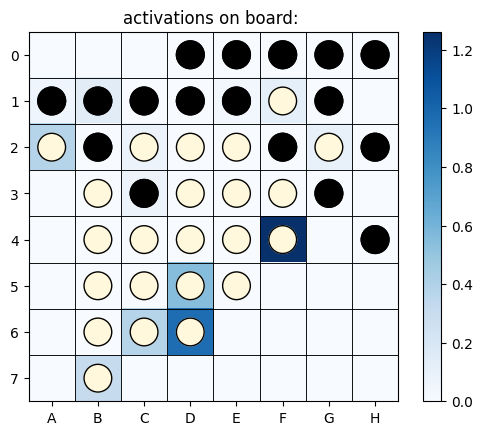

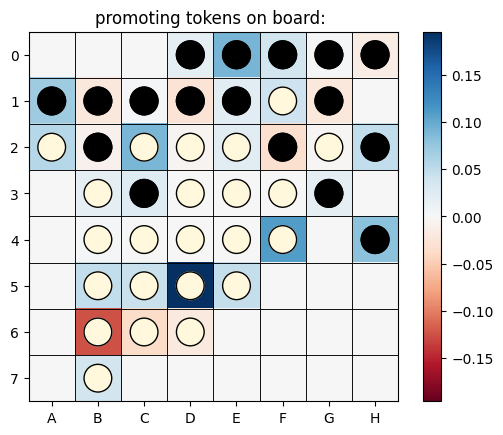

Top 10 example:


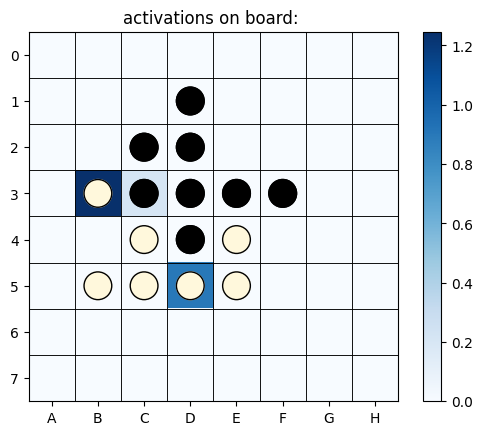

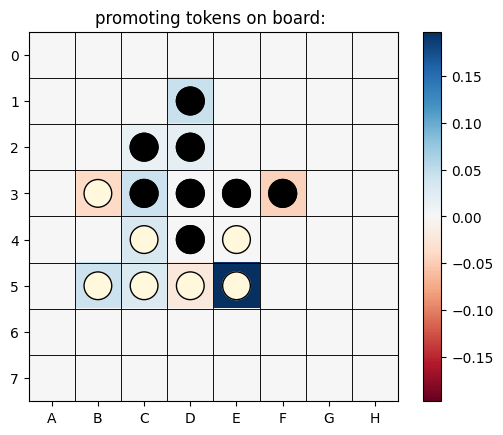

In [104]:
# set idx to be the index of the (alive) feature you want to visualize
idx = 4
feat_idx = results['alive_features'][idx]
print("Board states that the feature classifies according to Adam's measurements:")
print((results['board_to_piece_state'][0][idx] > .95).nonzero())
print("Number of such board states:")
print((results['board_to_piece_state'][0][idx] > .95).sum())

contexts, activations, attributions = visualize(model, ae, buffer, feat_idx, k=10)